In [1]:
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime
import kagglehub
import time
import gc
import torch.optim as optim
from torchvision import models
import glob
import torchvision.datasets as datasets
import pandas as pd

In [2]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download the dataset
data_dir = kagglehub.dataset_download("alessiocorrado99/animals10")
data_dir = os.path.join(data_dir, 'raw-img')
print("Path to dataset files:", data_dir)

# Classes and dataset setup
classes = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider"
}

data = {
    "path": [],
    "label": []
}

# Read image paths and labels
for label_it, label_en in classes.items():
    paths = glob.glob(f'{data_dir}/{label_it}/*.jpeg')
    data["path"].extend(paths)
    data["label"].extend([label_en] * len(paths))

df_data = pd.DataFrame(data)
df_data.head()

num_epochs = 1
batch_size = 32
learning_rate = 0.001

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to InceptionV3 input size
    transforms.RandomHorizontalFlip(),  # Lightweight augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
Dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Print dataset statistics after initializing Dataset
num_classes = len(Dataset.classes)
num_samples = len(Dataset)
print(f"Number of classes: {num_classes}")
print(f"Number of samples: {num_samples}")

# Split dataset into train and test
train_size = int(0.8 * len(Dataset))  # 80% for training
test_size = len(Dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(Dataset, [train_size, test_size])

# Create data loaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img
Number of classes: 10
Number of samples: 26179


In [5]:
import torch
from torchvision import models
import torch.nn as nn

# Function to initialize and modify the InceptionV3 model
def initialize_inceptionv3(num_classes, device):
    """
    Initialize and modify the InceptionV3 model for a specific number of classes.
    
    Args:
        num_classes (int): Number of output classes.
        device (torch.device): The device to load the model onto (CPU/GPU).
    
    Returns:
        model (torch.nn.Module): Modified InceptionV3 model.
    """
    # Load the pre-trained InceptionV3 model
    model = models.inception_v3(weights='Inception_V3_Weights.DEFAULT')

    # Modify the fully connected layer to match the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # InceptionV3 requires aux_logits=False during inference or if not used
    model.aux_logits = False  # Disable auxiliary classifier for simplicity

    # Move the model to the specified device
    model = model.to(device)

    return model

# Define the number of classes (adjust based on your dataset)
NUM_CLASSES = 10  # Update based on your dataset

# Force the device to CPU regardless of GPU availability
DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

# Initialize the InceptionV3 model
model = initialize_inceptionv3(NUM_CLASSES, DEVICE)

# Print model summary
print("Modified InceptionV3 Model:")
print(model)


Using device: cpu
Modified InceptionV3 Model:
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (c

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import gc

# Create a directory to save logs if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file_path = os.path.join(log_dir, "inceptionv3_training_logs.txt")

# Arrays to store batch times for training and validation
train_batch_times = []
validation_batch_times = []

# Arrays to store training and validation metrics
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

total_step = len(train_loader)
device = torch.device("cpu")
# Set up optimizer and loss function for InceptionV3
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Open log file for writing
with open(log_file_path, "w") as log_file:
    def log_and_print(message):
        log_file.write(message + "\n")
        print(message)

    log_and_print("Training and Validation Logs for InceptionV3")
    log_and_print("=" * 50)

    for epoch in range(num_epochs):
        epoch_loss = 0  # Accumulate loss for the epoch
        epoch_start_time = time.time()  # Start epoch timer
        correct_train = 0
        total_train = 0

        log_and_print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

        for i, (images, labels) in enumerate(train_loader):
            batch_start_time = time.time()  # Start batch timer

            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Clean up
            del images, labels, outputs
         
            gc.collect()

            # Update epoch loss
            epoch_loss += loss.item()

            # Record batch time
            batch_end_time = time.time()
            batch_time = batch_end_time - batch_start_time
            train_batch_times.append(batch_time)

            # Log and print progress every 10 batches
            if (i + 1) % 10 == 0:
                log_and_print(f"Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Batch Time: {batch_time:.2f} seconds")

        epoch_end_time = time.time()  # End epoch timer
        avg_epoch_loss = epoch_loss / total_step
        training_losses.append(avg_epoch_loss)
        training_accuracy = 100 * correct_train / total_train
        training_accuracies.append(training_accuracy)

        log_and_print(f"Epoch [{epoch + 1}/{num_epochs}] completed. Average Loss: {avg_epoch_loss:.4f}")
        log_and_print(f"Training Accuracy: {training_accuracy:.2f} %")
        log_and_print(f"Total Time for Epoch {epoch + 1}: {epoch_end_time - epoch_start_time:.2f} seconds")

        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            validation_loss = 0
            validation_start_time = time.time()  # Start validation timer

            log_and_print("Starting Validation...")

            for i, (images, labels) in enumerate(test_loader):
                batch_start_time = time.time()  # Start batch timer

                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                # Compute predictions
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Compute validation loss
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                # Record validation batch time
                batch_end_time = time.time()
                batch_time = batch_end_time - batch_start_time
                validation_batch_times.append(batch_time)

                # Log progress every 10 validation batches
                if (i + 1) % 10 == 0:
                    log_and_print(f"Validation Step [{i + 1}/{len(test_loader)}], Batch Time: {batch_time:.2f} seconds")

                # Clean up
                del images, labels, outputs
  
                gc.collect()

            validation_end_time = time.time()  # End validation timer
            avg_validation_loss = validation_loss / len(test_loader)
            validation_losses.append(avg_validation_loss)
            accuracy = 100 * correct / total
            validation_accuracies.append(accuracy)

            log_and_print(f"Accuracy of the network on the validation set: {accuracy:.2f} %")
            log_and_print(f"Validation Loss: {avg_validation_loss:.4f}")
            log_and_print(f"Total Validation Time: {validation_end_time - validation_start_time:.2f} seconds")

# Save batch times for training and validation to separate files
train_times_path = os.path.join(log_dir, "train_batch_times.txt")
validation_times_path = os.path.join(log_dir, "validation_batch_times.txt")

with open(train_times_path, "w") as train_file:
    train_file.write("\n".join([f"{time:.4f}" for time in train_batch_times]))

with open(validation_times_path, "w") as val_file:
    val_file.write("\n".join([f"{time:.4f}" for time in validation_batch_times]))

# log_and_print(f"Logs and batch times saved in '{log_dir}' directory.")


Training and Validation Logs for InceptionV3

Epoch [1/1]


In [ ]:

# Get the current date and time
current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Get the current working directory
log_dir = os.getcwd()

# Save the ResNet18 model with a timestamp in the filename
model_save_path = os.path.join(log_dir, f"inceptionv3_trained_model_{current_timestamp}-before-results-measuring.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at '{model_save_path}' for later usage.")

In [ ]:
import os
from datetime import datetime
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Create a results directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"inceptionv3_results_{timestamp}"
os.makedirs(results_dir, exist_ok=True)

# Function to save a plot with 'inceptionv3' in the file name
def save_plot(data, xlabel, ylabel, title, filename, is_line_plot=True):
    plt.figure()
    if is_line_plot:
        plt.plot(data)
    else:
        sns.barplot(x=list(range(len(data))), y=data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # Save with 'inceptionv3' in the filename
    plt.savefig(os.path.join(results_dir, f"inceptionv3_{filename}"))
    plt.close()

# Save training and validation batch times
save_plot(train_batch_times, "Batch Number", "Time (seconds)", "Training Batch Times", "inceptionv3_train_batch_times.png")
save_plot(validation_batch_times, "Batch Number", "Time (seconds)", "Validation Batch Times", "inceptionv3_validation_batch_times.png")

# Compute confusion matrix and classification report after the final epoch
def evaluate_model_on_test():
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    # Save with 'inceptionv3' in the filename
    plt.savefig(os.path.join(results_dir, "inceptionv3_confusion_matrix.png"))
    plt.close()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)], output_dict=True)
    report_str = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)])
    print(report_str)  # Print to console
    # Save the classification report with 'inceptionv3' in the filename
    with open(os.path.join(results_dir, "inceptionv3_classification_report.txt"), "w") as f:
        f.write(report_str)

    return cm, report

confusion_matrix_data, classification_report_data = evaluate_model_on_test()

# Save training and validation loss and accuracy curves
# Assuming `training_losses`, `validation_losses`, `training_accuracies`, `validation_accuracies` lists are collected during training
save_plot(training_losses, "Epoch", "Loss", "Training Loss Curve", "inceptionv3_training_loss_curve.png")
save_plot(validation_losses, "Epoch", "Loss", "Validation Loss Curve", "inceptionv3_validation_loss_curve.png")
save_plot(training_accuracies, "Epoch", "Accuracy (%)", "Training Accuracy Curve", "inceptionv3_training_accuracy_curve.png")
save_plot(validation_accuracies, "Epoch", "Accuracy (%)", "Validation Accuracy Curve", "inceptionv3_validation_accuracy_curve.png")

# Save the model architecture and training configuration
with open(os.path.join(results_dir, "inceptionv3_model_summary.txt"), "w") as f:
    f.write(str(model))
    f.write("\n\nTraining Configuration:\n")
    f.write(f"Number of Epochs: {num_epochs}\n")
    f.write(f"Learning Rate: {learning_rate}\n")
    f.write(f"Optimizer: SGD (momentum=0.9, weight_decay=0.001)\n")
    f.write(f"Loss Function: CrossEntropyLoss\n")

# Save overall results and metrics
overall_results = {
    "Average Training Batch Time": np.mean(train_batch_times),
    "Average Validation Batch Time": np.mean(validation_batch_times),
    "Final Validation Accuracy": classification_report_data["accuracy"] * 100,
}
with open(os.path.join(results_dir, "inceptionv3_overall_results.txt"), "w") as f:
    for key, value in overall_results.items():
        f.write(f"{key}: {value:.2f}\n")

print(f"Reports and visualizations saved in '{results_dir}' directory.")

# Get the current date and time for model save
current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Save the model with a timestamp in the filename
model_save_path = os.path.join(results_dir, f"inceptionv3_trained_model_{current_timestamp}.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at '{model_save_path}' for later usage.")


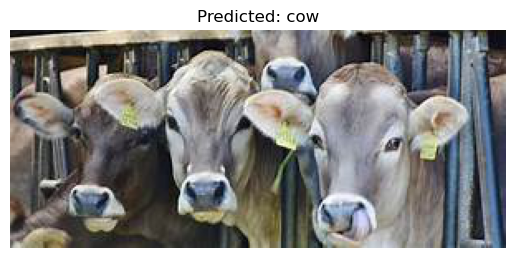

In [56]:

# Define batch size and image dimensions
BATCH_SIZE = 32
IMG_HEIGHT = 128  # Adjust according to your dataset
IMG_WIDTH = 128   # Adjust according to your dataset

# Define the translation dictionary
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", 
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", 
    "scoiattolo": "squirrel", "dog": "cane", "horse": "cavallo", "elephant": "elefante", 
    "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", 
    "spider": "ragno", "squirrel": "scoiattolo"
}

# Define the categories (class names your model predicts)
categories = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

# Define the dataset directory path (replace with your actual path)
dataset_dir = r'C:\Users\hp\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img'

# Define the transformations to match what was done during training
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # Resize to match model input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

# Load the pre-trained InceptionV3 model and modify the final layer
model = models.inception_v3(pretrained=False)  # Load InceptionV3 without the weights
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, len(categories))  # Modify the auxiliary output layer
model.fc = nn.Linear(model.fc.in_features, len(categories))  # Modify the final layer to match the number of classes

# Load the saved model weights (ensure this path is correct relative to your script)
model_path = 'inceptionv3_trained_model.pth'  # Using relative path if the model is in the same directory
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Function to test a random image from each class
def test_random_images(model, categories, dataset_dir, transform):
    model.eval()  # Set the model to evaluation mode
    for category in categories:
        # Get all image files in the current category directory
        class_dir = os.path.join(dataset_dir, category)
        image_files = os.listdir(class_dir)
        
        # Select a random image
        random_image = random.choice(image_files)
        image_path = os.path.join(class_dir, random_image)
        
        # Open and preprocess the image
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
        
        # Make prediction
        with torch.no_grad():
            outputs = model(img_tensor)  # Get model output
            _, predicted_class_idx = torch.max(outputs, 1)  # Get index of the max value in the output
        
        # Get the predicted class label
        predicted_class_label = categories[predicted_class_idx.item()]  # Convert the index to class label
        
        # Translate the predicted class label
        translated_label = translate.get(predicted_class_label, predicted_class_label)  # Get the translated label or keep the original if not found
        
        # Display the image and the translated prediction
        plt.imshow(img)
        plt.title(f" Actual : {category} Predicted: {translated_label} {predicted_class_label}")
        plt.axis('off')  # Hide the axes for a cleaner view
        plt.show()

# Test random images from each class
test_random_images(model, categories, dataset_dir, transform)
